In [16]:
import pandas as pd, time, requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import chardet
import re
from tqdm import tqdm

# **1.Loading our datasets 2023 and 2013 TRI datasets**

the 2023 and 2013 _us.csv dataset loaded in

In [6]:
# Load both years (update file paths if needed)
df2013 = pd.read_csv("2013_us.csv", low_memory=False)
#print(df2013.head())

#df2023 = pd.read_csv("2023_us.csv", low_memory=False)
#encoding error error

# Detect encoding ( apply a safe fallback)
with open('2023_us.csv', 'rb') as f:
    result = chardet.detect(f.read(100000))

print("Detected encoding for 2023_us.csv:", result)

# Force a safe fallback if ascii or None detected
encoding_used = result['encoding']
if encoding_used is None or encoding_used.lower() in ['ascii', 'utf-8']:
    encoding_used = 'latin1'  # fallback to a tolerant encoding

# Read CSV safely
df2023 = pd.read_csv('2023_us.csv', encoding=encoding_used, on_bad_lines='skip')

print(f"\n Loaded successfully using encoding: {encoding_used}")
#print(df2023.head())


Detected encoding for 2023_us.csv: {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

 Loaded successfully using encoding: latin1


/tmp/ipython-input-2375228526.py:20: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df2023 = pd.read_csv('2023_us.csv', encoding=encoding_used, on_bad_lines='skip')


# **2.Merged Datasets**


In [8]:
# Merge both datasets together
merged_df = pd.concat([df2013, df2023], ignore_index=True)

# Save combined dataset
merged_df.to_csv("MergedDataset.csv", index=False)
print("Successfully merged both years : MergedDataset.csv")

# Quick check
print("Years in merged file:", merged_df["1. YEAR"].unique())
print("Record counts per year:")
print(merged_df["1. YEAR"].value_counts())

Successfully merged both years : MergedDataset.csv
Years in merged file: [2013 2023]
Record counts per year:
1. YEAR
2013    83357
2023    78589
Name: count, dtype: int64


In [9]:
# print(merged_df.head())

   1. YEAR         2. TRIFD     3. FRS ID               4. FACILITY NAME  \
0     2013  44839THGLD300SP  1.100004e+11        AKZO NOBEL COATINGS INC   
1     2013  77536WRGRC739BA  1.100005e+11        GEO SPECIALTY CHEMICALS   
2     2013  98632WYRHS3401I  1.100005e+11  NIPPON DYNAWAVE PACKAGING CO.   
3     2013  84078QDRCH1575S  1.100253e+11           BRENNTAG PACIFIC INC   
4     2013  43302VRHDD1295F  1.100004e+11     OVERHEAD DOOR CO TODCO DIV   

                                  5. STREET ADDRESS    6. CITY 7. COUNTY  \
0                                     300 SPROWL RD      HURON      ERIE   
1  739 INDEPENDENCE PKWY (FORMERLY BATTLEGROUND RD)  DEER PARK    HARRIS   
2                               3401 INDUSTRIAL WAY   LONGVIEW   COWLITZ   
3                                     1575 S 1625 E     VERNAL    UINTAH   
4                              1295 FAIRGROUND RD E     MARION    MARION   

  8. ST  9. ZIP  10. BIA  ... 113. 8.2 - ENERGY RECOVER ON  \
0    OH   44839      NaN

# **3.Drop Colunms**

In [10]:

merged_df.columns = merged_df.columns.str.strip()

# Update column names to match the dataset
keep_cols = [
    "1. YEAR",
    "4. FACILITY NAME",
    "37. CHEMICAL",
    "23. INDUSTRY SECTOR",
    "40. CAS#",
    "107. TOTAL RELEASES", # Assuming this is the correct total releases column
    "12. LATITUDE",
    "13. LONGITUDE"
]

print("Columns found in dataset:\n", merged_df.columns.tolist())
print("\nAttempting to keep these columns:\n", keep_cols)

existing_cols = [col for col in keep_cols if col in merged_df.columns]
filtered_merged_df = merged_df[existing_cols].copy()

# Rename columns for easier use
rename_map = {
    "1. YEAR": "YEAR",
    "4. FACILITY NAME": "FACILITY_NAME",
    "23. INDUSTRY SECTOR": "INDUSTRY_SECTOR",
    "37. CHEMICAL": "CHEMICAL",
    "40. CAS#": "CAS#",
    "107. TOTAL RELEASES": "Mass_Released_kg",
    "12. LATITUDE": "LATITUDE",
    "13. LONGITUDE": "LONGITUDE"
}
filtered_merged_df = filtered_merged_df.rename(columns=rename_map)


filtered_merged_df.to_csv("Filtered_CO2_Dataset1.csv", index=False)

# print("Filtered dataset saved as 'Filtered_CO2_Dataset1.csv'")
# print("Columns in filtered file:", list(filtered_merged_df.columns))
# print("Preview:")
# print(filtered_merged_df.head())


Columns found in dataset:
 ['1. YEAR', '2. TRIFD', '3. FRS ID', '4. FACILITY NAME', '5. STREET ADDRESS', '6. CITY', '7. COUNTY', '8. ST', '9. ZIP', '10. BIA', '11. TRIBE', '12. LATITUDE', '13. LONGITUDE', '14. HORIZONTAL DATUM', '15. PARENT CO NAME', '16. PARENT CO DB NUM', '17. STANDARD PARENT CO NAME', '18. FOREIGN PARENT CO NAME', '19. FOREIGN PARENT CO DB NUM', '20. STANDARD FOREIGN PARENT CO NAME', '21. FEDERAL FACILITY', '22. INDUSTRY SECTOR CODE', '23. INDUSTRY SECTOR', '24. PRIMARY SIC', '25. SIC 2', '26. SIC 3', '27. SIC 4', '28. SIC 5', '29. SIC 6', '30. PRIMARY NAICS', '31. NAICS 2', '32. NAICS 3', '33. NAICS 4', '34. NAICS 5', '35. NAICS 6', '36. DOC_CTRL_NUM', '37. CHEMICAL', '38. ELEMENTAL METAL INCLUDED', '39. TRI CHEMICAL/COMPOUND ID', '40. CAS#', '41. SRS ID', '42. CLEAN AIR ACT CHEMICAL', '43. CLASSIFICATION', '44. METAL', '45. METAL CATEGORY', '46. CARCINOGEN', '47. PBT', '48. PFAS', '49. FORM TYPE', '50. UNIT OF MEASURE', '51. 5.1 - FUGITIVE AIR', '52. 5.2 - STACK A

# **4.Filtering and Identifying Carbon-Containing Chemicals from the Dataset**

This section loads the cleaned emissions dataset and applies a targeted filtering process to identify chemicals that likely contain carbon. After removing rows missing key identifiers, a custom detection function is used to distinguish organic (carbon-containing) compounds from inorganic species.
The filtered results are then reduced to unique chemical–CAS pairs and exported to a CSV file for further analysis. This ensures that only relevant carbon-containing chemicals are retained for downstream CO₂ estimation or modeling tasks.

In [15]:
# Load filtered merged dataset
df = pd.read_csv("Filtered_CO2_Dataset1.csv", low_memory=False)
df.columns = df.columns.str.strip()

# --- Drop rows missing essential info ---
df = df.dropna(subset=["CHEMICAL", "CAS#"])

# --- Define a robust carbon-detection function ---
def contains_carbon(name):
    """Return True if a chemical name likely contains carbon."""
    name = str(name).upper()

    inorganic_terms = [
        "AMMONIA", "HYDROGEN", "NITRIC", "SULFUR", "SULPHUR",
        "CHLORINE", "CHLORIDE", "NITROGEN", "OXYGEN", "ZINC",
        "COPPER", "IRON", "ALUMINIUM", "ALUMINUM", "LEAD", "MERCURY",
        "SODIUM", "POTASSIUM", "CALCIUM", "MAGNESIUM", "NICKEL",
        "CHROMIUM", "MANGANESE", "ARSENIC", "CADMIUM", "SILVER",
        "COBALT", "TIN", "ANTIMONY", "SELENIUM"
    ]
    organic_terms = [
        "CARBON", "BENZ", "METH", "ETH", "PROP", "BUT", "HEX", "CYCLO",
        "TOLU", "PHEN", "ACET", "NAPHTH", "FORM", "STYRENE", "XYLENE"
    ]
    # Rule out inorganics
    if any(term in name for term in inorganic_terms):
        return False
    # Flag common organic/HC patterns
    return any(key in name for key in organic_terms)

# --- Apply filter for carbon-containing chemicals ---
carbon_df = df[df["CHEMICAL"].apply(contains_carbon)].copy()

# --- Extract unique chemical–CAS pairs ---
carbon_unique = (
    carbon_df[["CHEMICAL", "CAS#"]]
    .drop_duplicates()
    .sort_values("CHEMICAL")
    .reset_index(drop=True)
)

# --- Save output ---
carbon_unique.to_csv("carbon_containing_chemicals.csv", index=False)

# print(f"Found {len(carbon_unique)} unique carbon-containing chemicals.")
# print("Saved to 'carbon_containing_chemicals.csv'")
# print("\nSample preview:")
# print(carbon_unique.head(15))

Found 317 unique carbon-containing chemicals.
Saved to 'carbon_containing_chemicals.csv'

Sample preview:
                                             CHEMICAL        CAS#
0      1,1,1,2-Tetrachloro-2-fluoroethane (HCFC-121a)    354-11-0
1                           1,1,1,2-Tetrachloroethane    630-20-6
2                               1,1,1-Trichloroethane     71-55-6
3       1,1,2,2-Tetrachloro-1-fluoroethane (HCFC-121)    354-14-3
4                           1,1,2,2-Tetrachloroethane     79-34-5
5                               1,1,2-Trichloroethane     79-00-5
6   1,1-Dichloro-1,2,2,3,3-pentafluoropropane (HCF...  13474-88-9
7             1,1-Dichloro-1-fluoroethane (HCFC-141b)   1717-00-6
8                               1,1-Dimethylhydrazine     57-14-7
9                              1,2,3-Trichloropropane     96-18-4
10                             1,2,4-Trichlorobenzene    120-82-1
11                             1,2,4-Trimethylbenzene     95-63-6
12                                 1

# **5.Retrieving Molecular Formulas from PubChem and Computing Carbon Fractions for Each Chemical**

This section reads the list of identified carbon-containing chemicals and uses the PubChem PUG REST API to retrieve each compound’s molecular formula and molecular weight based on its CAS number.A parsing function extracts the number of carbon atoms from each molecular formula, which is then used to calculate the percentage of the molecule’s mass that is due to carbon (carbon fraction). The script iterates through all chemicals with polite rate-limiting, storing successful lookups in a carbon-fraction table while tracking any unmatched CAS numbers that require manual verification.

(This part take a couple minutes approx.5min )

In [17]:

INPUT = "carbon_containing_chemicals.csv"
OUT_LOOKUP = "carbon_fractions_lookup.csv"
OUT_UNMATCH = "UNMATCHED_no_pubchem_hit.csv"

def count_c_atoms(formula: str) -> int:
    # Parse e.g. "C6H6Cl2" -> 6 ; "C" -> 1 ; "C10H14N2" -> 10
    if not formula or pd.isna(formula):
        return 0
    m = re.search(r"C(\d*)", formula)
    if not m:
        return 0
    num = m.group(1)
    return int(num) if num else 1

def fetch_pubchem_by_cas(cas: str):
    # PUG REST: get molecular formula & molecular weight by CAS registry
    # docs: https://pubchem.ncbi.nlm.nih.gov/docs/pug-rest
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{requests.utils.quote(cas)}/property/MolecularFormula,MolecularWeight/JSON"
    r = requests.get(url, timeout=15)
    if r.status_code != 200:
        return None
    try:
        props = r.json()["PropertyTable"]["Properties"][0]
        return {
            "MolecularFormula": props.get("MolecularFormula"),
            "MolecularWeight": float(props.get("MolecularWeight")) if props.get("MolecularWeight") else None,
        }
    except Exception:
        return None

df = pd.read_csv(INPUT).dropna(subset=["CAS#"]).copy()
df["CAS#"] = df["CAS#"].astype(str).str.strip()

rows = []
unmatched = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    chem = str(row["CHEMICAL"]).strip()
    cas  = str(row["CAS#"]).strip()
    info = fetch_pubchem_by_cas(cas)
    # polite throttle to avoid hammering the API
    time.sleep(0.1)

    if not info or not info.get("MolecularWeight") or not info.get("MolecularFormula"):
        unmatched.append({"CHEMICAL": chem, "CAS#": cas})
        continue

    formula = info["MolecularFormula"]
    mw = info["MolecularWeight"]
    c_atoms = count_c_atoms(formula)
    if c_atoms == 0 or not mw:
        unmatched.append({"CHEMICAL": chem, "CAS#": cas})
        continue

    carbon_fraction = (12.011 * c_atoms / mw) * 100.0
    rows.append({
        "CHEMICAL": chem,
        "CAS#": cas,
        "Formula": formula,
        "MolecularWeight": mw,
        "C_atoms": c_atoms,
        "Carbon_Fraction": round(carbon_fraction, 2)
    })

lookup = pd.DataFrame(rows).drop_duplicates(subset=["CAS#"]).sort_values("CHEMICAL")
lookup.to_csv(OUT_LOOKUP, index=False)

pd.DataFrame(unmatched).drop_duplicates().to_csv(OUT_UNMATCH, index=False)

print(f"Saved {len(lookup)} rows → {OUT_LOOKUP}")
print(f"Unmatched (needs manual check) → {OUT_UNMATCH}")
lookup.head(10)


100%|██████████| 317/317 [04:14<00:00,  1.24it/s]

Saved 289 rows → carbon_fractions_lookup.csv
Unmatched (needs manual check) → UNMATCHED_no_pubchem_hit.csv


,CHEMICAL,CAS#,Formula,MolecularWeight,C_atoms,Carbon_Fraction
0,"1,1,1,2-Tetrachloro-2-fluoroethane (HCFC-121a)",354-11-0,C2HCl4F,185.80,2,12.93
1,"1,1,1,2-Tetrachloroethane",630-20-6,C2H2Cl4,167.80,2,14.32
2,"1,1,1-Trichloroethane",71-55-6,C2H3Cl3,133.40,2,18.01
3,"1,1,2,2-Tetrachloro-1-fluoroethane (HCFC-121)",354-14-3,C2HCl4F,185.80,2,12.93
4,"1,1,2,2-Tetrachloroethane",79-34-5,C2H2Cl4,167.80,2,14.32
5,"1,1,2-Trichloroethane",79-00-5,C2H3Cl3,133.40,2,18.01
6,"1,1-Dichloro-1,2,2,3,3-pentafluoropropane (HCF...",13474-88-9,C3HCl2F5,202.93,3,17.76
7,"1,1-Dichloro-1-fluoroethane (HCFC-141b)",1717-00-6,C2H3Cl2F,116.95,2,20.54
8,"1,1-Dimethylhydrazine",57-14-7,C2H8N2,60.10,2,39.97
9,"1,2,3-Trichloropropane",96-18-4,C3H5Cl3,147.43,3,24.44


# **6.Merging Carbon Fractions with the Emissions Dataset and Computing CO₂ Estimates**

In this step, the filtered TRI emissions dataset is merged with the previously generated carbon-fraction lookup table using the CAS number as the key. Rows lacking a matched carbon fraction are removed to ensure accurate downstream calculations. For each remaining chemical release, the script computes the estimated mass of CO₂ generated using the standard molecular conversion factor
44/12
, which converts carbon mass to the equivalent CO₂ mass.

The final dataset—including all facilities, chemicals, and computed CO₂ emissions

In [19]:
filtered = pd.read_csv("Filtered_CO2_Dataset1.csv")
lookup = pd.read_csv("carbon_fractions_lookup.csv")

merged = pd.merge(filtered, lookup[["CAS#","Carbon_Fraction"]], on="CAS#", how="left")
merged = merged.dropna(subset=["Carbon_Fraction"])

merged["CO2_kg"] = merged["Mass_Released_kg"] * (merged["Carbon_Fraction"]/100) * (44/12)
merged.to_csv("TRI_CO2_estimates.csv", index=False)

print("CO₂ estimates created → TRI_CO2_estimates.csv")
merged.head()


CO₂ estimates created → TRI_CO2_estimates.csv


,YEAR,FACILITY_NAME,CHEMICAL,INDUSTRY_SECTOR,CAS#,Mass_Released_kg,LATITUDE,LONGITUDE,Carbon_Fraction,CO2_kg
1,2013,GEO SPECIALTY CHEMICALS,Formaldehyde,Chemicals,50-00-0,2679.260,29.718520,-95.089680,40.00,3929.581333
3,2013,BRENNTAG PACIFIC INC,Ethylbenzene,Chemical Wholesalers,100-41-4,0.000,40.433509,-109.497195,90.51,0.000000
8,2013,PERDUE AGRIBUSINESS LLC - COFIELD NC,n-Hexane,Food,110-54-3,133560.000,36.363424,-76.899292,83.62,409503.864000
10,2013,FORMOSA PLASTICS CORP TEXAS,"1,1,2-Trichloroethane",Chemicals,79-00-5,103.000,28.697590,-96.542101,18.01,68.017767
15,2013,OLYMPUS TERMINALS LLC,Naphthalene,Petroleum Bulk Terminals,91-20-3,20.497,33.751629,-118.208842,93.71,70.428375


# **Exploratory**

In [ ]:
final= pd.read_csv("TRI_CO2_estimates.csv")

In [ ]:
print(final.info())
print(final.describe())
print(final.isnull().sum())

/tmp/ipython-input-3071493128.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="YEAR", y="CO2_Mt", data=yearly, palette="coolwarm")


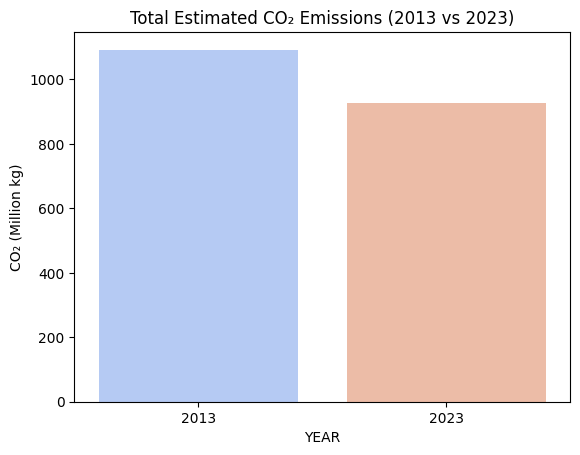

   YEAR        CO2_kg       CO2_Mt
0  2013  1.092247e+09  1092.247292
1  2023  9.282979e+08   928.297868


In [20]:
# final= pd.read_csv("TRI_CO2_estimates.csv")
final["YEAR"] = final["YEAR"].astype(int)

yearly = final.groupby("YEAR")["CO2_kg"].sum().reset_index()
yearly["CO2_Mt"] = yearly["CO2_kg"]/1e6

sns.barplot(x="YEAR", y="CO2_Mt", data=yearly, palette="coolwarm")
plt.title("Total Estimated CO₂ Emissions (2013 vs 2023)")
plt.ylabel("CO₂ (Million kg)")
plt.show()

print(yearly)

This bar chart compares the total estimated CO₂ emissions from TRI facilities for the two available reporting years, 2013 and 2023. The emissions for each year are computed by summing the CO₂ output of all facilities and all reported chemicals, then converting the totals into million kilograms (Mt) for easier comparison. Each bar represents the aggregate national CO₂ emissions for that year.

/tmp/ipython-input-2274151006.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="FACILITY_NAME", x="CO2_kg", data=top10, palette="rocket")


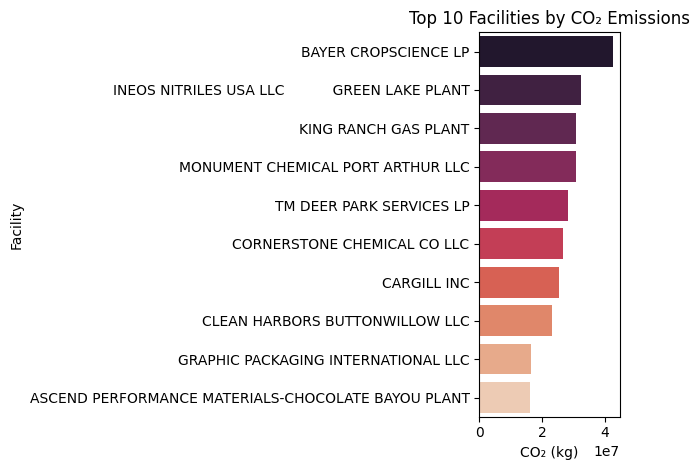

In [21]:
grouped = (
    final.groupby("FACILITY_NAME")[["Mass_Released_kg","CO2_kg"]]
    .sum().reset_index().sort_values("CO2_kg", ascending=False)
)
top10 = grouped.head(10)

sns.barplot(y="FACILITY_NAME", x="CO2_kg", data=top10, palette="rocket")
plt.title("Top 10 Facilities by CO₂ Emissions")
plt.xlabel("CO₂ (kg)")
plt.ylabel("Facility")
plt.tight_layout()
plt.show()


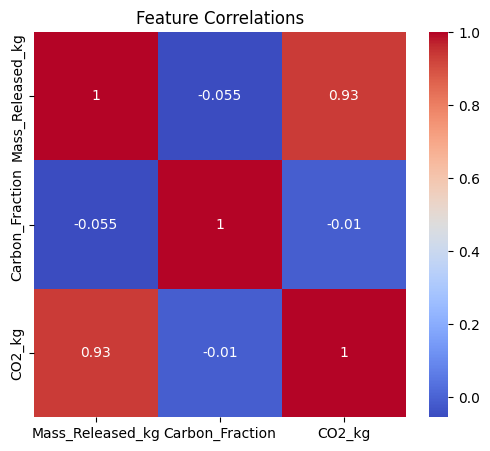

In [22]:
plt.figure(figsize=(6,5))
sns.heatmap(final[["Mass_Released_kg", "Carbon_Fraction", "CO2_kg"]].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()